In [10]:
import os
from contextlib import redirect_stdout
import numpy as np
import torch as T
import torch.nn as nn
from matplotlib import pyplot as plt
import seaborn as sns
from datagenerator import makesignal, get_params_from_json
from model import UNet1SnC  # Ensure this matches the model used in training

In [11]:
# Devices and file paths
device = T.device("cuda" if T.cuda.is_available() else "mps" if T.backends.mps.is_available() else "cpu")
print("Using device:", device)

model_path = './savedmodels/modelFinal.pth'  # Path to the saved model
params_path = './Parameters/params.json'    # Path to the parameters file

Using device: mps


In [12]:
# Load model architecture and parameters
net = UNet1SnC(n_channels=1, n_classes=6)  # Ensure this matches the training model

net.load_state_dict(T.load(model_path, map_location=device, weights_only=True))

# Neater map that does not spew architecture
with open(os.devnull, 'w') as f, redirect_stdout(f):
    net.to(device)
    net.eval()  # Set the model to evaluation mode



In [148]:
# Load signal parameters and generate a test signal
params = get_params_from_json(params_path)
params['noise_level'] = 0.2  # Adjust noise level if needed

x_tmp, gt, signalclass = makesignal(params)  # Generate a test signal
x_tmp_exp = x_tmp[:, None]  # Add channel dimension
x = T.tensor(x_tmp_exp, dtype=T.float32).to(device)


In [149]:
# Run inference for dense segmentation
with T.no_grad():
    out, ws = net(x), None  # Adjust if `net` returns additional outputs

ShapeLikelihood = out[0].cpu().numpy().squeeze()  # Convert output to NumPy array


### The code below can be modified to different rendering styles/formats.

In [145]:
sns.set_theme(style='white')
sns.set(rc={'figure.figsize':(10,6)}, font_scale=2.5)
sns.set_style({'axes.facecolor':'white', 'grid.color': '.8', 'font.family':'Times New Roman'})

plt.rcParams.update({
    "text.usetex": True,
})

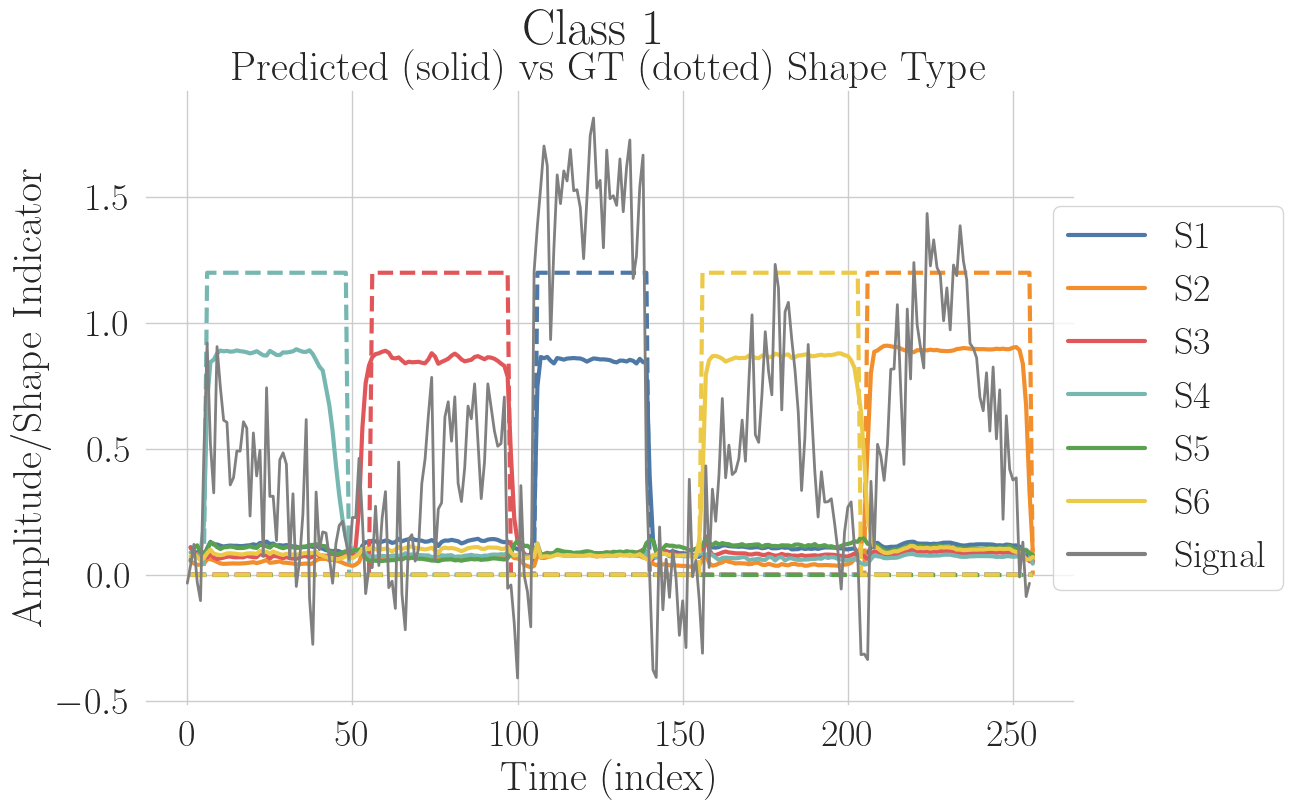

In [ ]:
# Visualize the results
fig = plt.figure(figsize=(12, 8))
ax = plt.gca()

# Modern color palette (Tableau 10)
colours = ['#4E79A7', '#F28E2B', '#E15759', '#76B7B2', '#59A14F', '#EDC948']

for i in range(ShapeLikelihood.shape[0]):
    plt.plot(np.arange(1, 257), 1.2 * gt[:, i], ls='--', lw=3, color=colours[i])  # Ground truth
    plt.plot(np.arange(1, 257), ShapeLikelihood[i, :], lw=3, color=colours[i])   # Predictions

plt.plot(x_tmp[0], ls='-', lw=2, color='#808080', label='Signal')

# Create a custom legend for the six classes
legend_handles = [plt.Line2D([0], [0], color=col, lw=3) for col in colours]
legend_handles.append(plt.Line2D([0], [0], color='#808080', lw=3))  # Add signal to legend
plt.legend(legend_handles, ['S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'Signal'], bbox_to_anchor=(1.1, 0.5), loc='center')

# Add labels and title
plt.xlabel('Time (index)')
plt.ylabel('Amplitude/Shape Indicator')
plt.title('Predicted (solid) vs GT (dotted) Shape Type')
plt.suptitle('Class ' + str(signalclass))

# Save the plot
plt.tight_layout()
plt.savefig('./Figures/DenseSegmentationInference.svg')
plt.show()

## Evaluation Code Below Here
Below this line, we run some evaluations over trial runs using different noise levels. 

Consider two cases, sampling _with replacement_ and _without replacement_, given that the model is trained without replacement of the shape waveforms from the pool of possible waveforms. The evaluation is done by comparing the model's predictions against the true labels.

```python

In [136]:
# Sampling without replacement selected implicitly below because the 
# original params.json file is used moslty without any change to generate the
# test signals. Only the noise parameter is varied.
NTrials = 500
NNoiseLevels = 10
NoiseLevels = np.linspace(0.1,1.0,NNoiseLevels)

# Load signal parameters and generate a test signal
params = get_params_from_json(params_path)
params['with_replacement'] = False  # Replacement is enabled for comparison trials

# Initialize arrays to store results
woJACCI = np.zeros((NTrials,NNoiseLevels))
JI = np.zeros(10)

# Threshold for shape likelihood
Thresh = 0.25

for i in range(NTrials):
    for j in range(NNoiseLevels):

        params['noise_level'] = NoiseLevels[j]  # Adjust noise level

        x_tmp, gt, signalclass = makesignal(params)  # Generate a test signal
        x_tmp_exp = x_tmp[:, None]  # Add channel dimension
        x = T.tensor(x_tmp_exp, dtype=T.float32).to(device) 

        out = net(x)[0].detach().squeeze().cpu().numpy()

        ShapeLikelihood = np.transpose(out)

        ShapeLikelihoodThresholded = ShapeLikelihood>Thresh
        Intersection = np.logical_and(ShapeLikelihoodThresholded, gt)
        Union = np.logical_or(ShapeLikelihoodThresholded, gt)
        Jaccard = np.sum(Intersection)/np.sum(Union)
        woJACCI[i,j] = Jaccard



In [137]:
# Below, we repeat the experiment, but now alter the model generation
# sampling with replacement - this means that each waveform may appear
# multiple times in each signal sample.
NTrials = 500
NNoiseLevels = 10
NoiseLevels = np.linspace(0.1,1.0,NNoiseLevels)

# Load signal parameters and generate a test signal
params = get_params_from_json(params_path)
params['with_replacement'] = True  # Replacement is enabled for comparison trials

# Initialize arrays to store results
wJACCI = np.zeros((NTrials,NNoiseLevels))
JI = np.zeros(10)

# Threshold for shape likelihood
Thresh = 0.25

for i in range(NTrials):
    for j in range(NNoiseLevels):

        params['noise_level'] = NoiseLevels[j]  # Adjust noise level

        x_tmp, gt, signalclass = makesignal(params)  # Generate a test signal
        x_tmp_exp = x_tmp[:, None]  # Add channel dimension
        x = T.tensor(x_tmp_exp, dtype=T.float32).to(device) 

        out = net(x)[0].detach().squeeze().cpu().numpy()

        ShapeLikelihood = np.transpose(out)

        ShapeLikelihoodThresholded = ShapeLikelihood>Thresh
        Intersection = np.logical_and(ShapeLikelihoodThresholded, gt)
        Union = np.logical_or(ShapeLikelihoodThresholded, gt)
        Jaccard = np.sum(Intersection)/np.sum(Union)
        wJACCI[i,j] = Jaccard



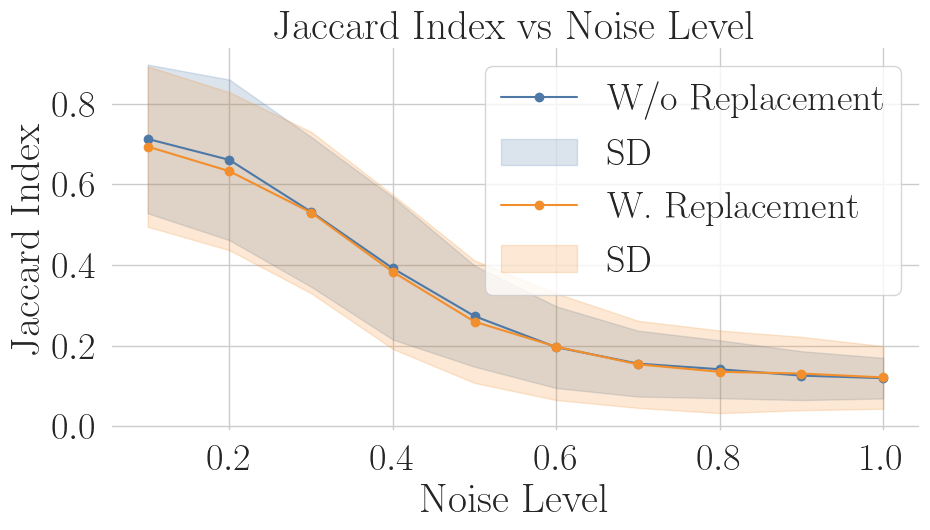

In [139]:
plt.plot(NoiseLevels, woJACCI.mean(axis=0), marker='o', color='#4E79A7', label='Mean Jaccard Index')

plt.fill_between(NoiseLevels, woJACCI.mean(axis=0) - woJACCI.std(axis=0), 
                 woJACCI.mean(axis=0) + woJACCI.std(axis=0), color='#4E79A7', alpha=0.2)

plt.plot(NoiseLevels, wJACCI.mean(axis=0), marker='o', 
         color='#F28E2B', label='Mean Jaccard Index')

plt.fill_between(NoiseLevels, wJACCI.mean(axis=0) - wJACCI.std(axis=0), 
                 wJACCI.mean(axis=0) + wJACCI.std(axis=0), color='#F28E2B', alpha=0.2)

plt.xlabel('Noise Level')
plt.ylabel('Jaccard Index')
plt.title('Jaccard Index vs Noise Level')
plt.legend(['W/o Replacement', 'SD', 'W. Replacement', 'SD'], loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.savefig('./Figures/JaccardIndexNoiseLevel.svg')